In [75]:
import pandas as pd
from scipy.stats import kstest
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from scipy.stats import norm
warnings.filterwarnings('ignore')
# plt.style.use('seaborn') #使用seaborn风格
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [22]:
df = pd.read_csv('order_train1.csv')
df.head()

,order_date,sales_region_code,item_code,first_cate_code,second_cate_code,sales_chan_name,item_price,ord_qty
0,2015-09-01,104,22069,307,403,offline,1114.0,19
1,2015-09-01,104,20028,301,405,offline,1012.0,12
2,2015-09-02,104,21183,307,403,online,428.0,109
3,2015-09-02,104,20448,308,404,online,962.0,3
4,2015-09-02,104,21565,307,403,offline,1400.0,3


In [ ]:
# 数据分析及数据处理

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 597694 entries, 0 to 597693
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   order_date         597694 non-null  object 
 1   sales_region_code  597694 non-null  int64  
 2   item_code          597694 non-null  int64  
 3   first_cate_code    597694 non-null  int64  
 4   second_cate_code   597694 non-null  int64  
 5   sales_chan_name    597694 non-null  object 
 6   item_price         597694 non-null  float64
 7   ord_qty            597694 non-null  int64  
dtypes: float64(1), int64(5), object(2)
memory usage: 36.5+ MB


In [23]:
df.isna().sum() #通过上述分析发现 不存在空值

order_date           0
sales_region_code    0
item_code            0
first_cate_code      0
second_cate_code     0
sales_chan_name      0
item_price           0
ord_qty              0
dtype: int64

In [24]:
len(df) #获取数据列表长度

597694

In [26]:
df.drop_duplicates(inplace=True) #去除重复值

In [27]:
len(df)
#通过上述发现有重复数据 597694-597382 = 312条重复数据

597382

In [34]:
def KsNormDetect(df):
    list_norm_T = []
    for col in df.columns:
        u = df[col].mean()  # 计算均值
        std = df[col].std()  # 计算标准差
        res=kstest(df[col], 'norm', (u, std))[1]
        if res >= 0.05:  # 判断p值是否服从正态分布，p<=0.05 则服从正态分布，否则不服从
            print(f'{col}该列数据不服从正态分布------')
            print('均值为：%.3f，标准差为：%.3f' % (u, std))
            print('-' * 40)
            list_norm_T.append(col)
        else:
            print(f'!!!{col}该列数据服从正态分布*********')
            print('均值为：%.3f，标准差为：%.3f' % (u, std))
            print('*' * 40)
KsNormDetect(df[['item_price', 'ord_qty']])

!!!item_price该列数据服从正态分布*********
均值为：1076.142，标准差为：1167.577
****************************************
!!!ord_qty该列数据服从正态分布*********
均值为：91.684，标准差为：199.887
****************************************


In [ ]:
# 可视化一些重要列的特性

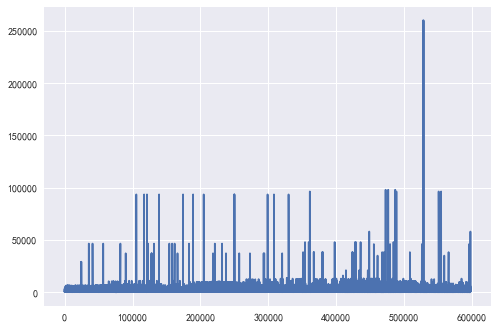

In [44]:
plt.plot(df['item_price'])
plt.show()

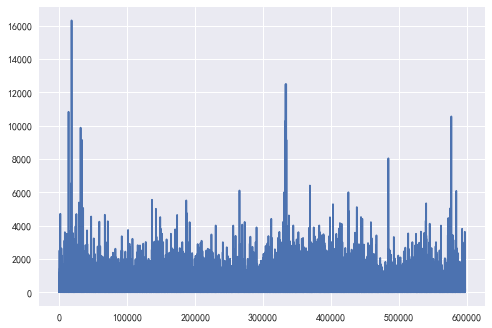

In [45]:
plt.plot(df['ord_qty'])
plt.show()

In [ ]:
# 可视化一些重要列的特性 箱线图法

<AxesSubplot:>

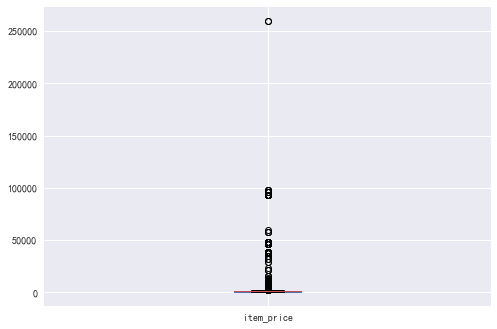

In [46]:
df.boxplot(column='item_price')

<AxesSubplot:>

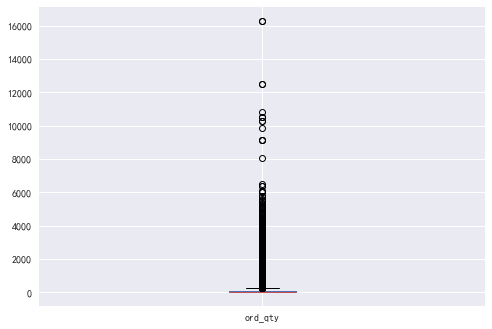

In [47]:
df.boxplot(column='ord_qty')

In [ ]:
# 通过上述分析可以得出初步结论 ord_qty item_price 符合正态分布

In [48]:
# 下面根据  筛选数据
# 利用3σ准则清理异常值，
# 基于3σ原则中的σ是代表标准差，3σ也就是标准差，
# 如果数据与均值之间的绝对距离大于3倍标准差，即下图中[-∞,μ-3σ]和[μ+3σ,+∞]部分，我们把这一部分值称为是异常值
def three_sigma(Ser1):
    """
    Ser1：表示传入DataFrame的某一列
    """
    rule = []
    u = Ser1.mean()  # 计算均值
    std = Ser1.std()  # 计算标准差
    for i in Ser1:
        if (i-u)/std > 3 or (i-u)/std < -3:
            rule.append(False)
        else:
            rule.append(True)
    out = Ser1.index[~np.array(rule)]
    return out

def delete_out3sigma(data, list_norm):
    """
    data：待检测的DataFrame；list_norm：服从正态分布的数据列名
    """
    out_index = []  # 保存要删除的行索引
    for col in list_norm:
        out_index.extend(three_sigma(data[col]))
    delete_ = list(set(out_index))  # 去除 out_index 中的重复元素
    data.drop(delete_,inplace=True)  # 根据 delete_ 删除对应行的数据
    df = data
    return df

df = delete_out3sigma(df, ['item_price', 'ord_qty'])

In [49]:
len(df)  # 597382 -582796 = 14586条异常数据

582796

In [ ]:
# 可视化清除异常值后的重要数据

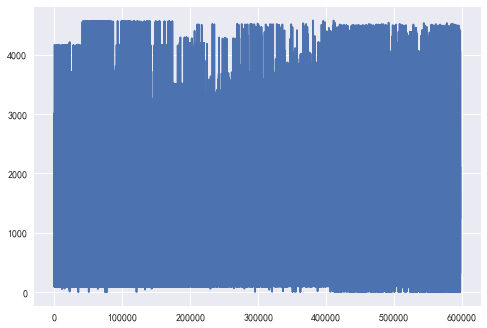

In [50]:
plt.plot(df['item_price'])
plt.show()

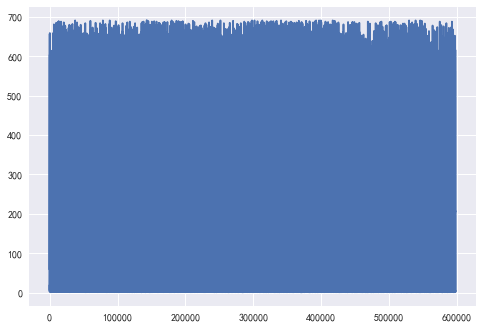

In [51]:
plt.plot(df['ord_qty'])
plt.show()

<AxesSubplot:>

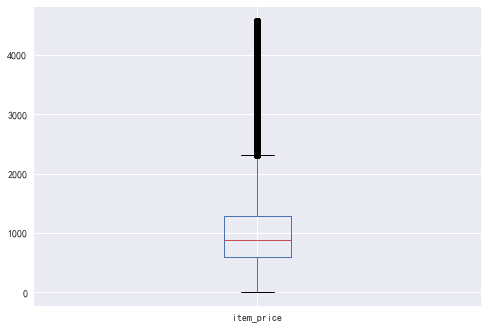

In [52]:
df.boxplot(column='item_price')

<AxesSubplot:>

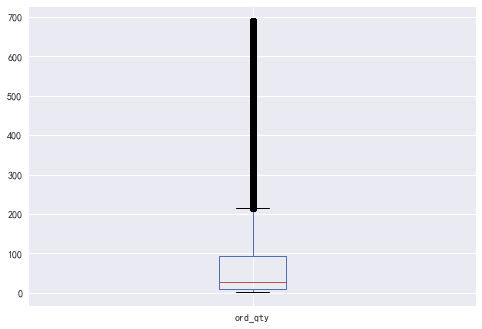

In [53]:
df.boxplot(column='ord_qty')

In [ ]:
# 通过上述图片发现数据变得平滑 证明我们数据清洗部分完成

In [ ]:
# 产品的不同价格对需求量的影响

In [54]:
grouped = df.groupby('item_price')['ord_qty'].mean().reset_index()

In [55]:
grouped.describe()

,item_price,ord_qty
count,13092.000000,13092.000000
mean,1489.666040,35.886193
std,1076.884529,57.724271
min,1.000000,1.000000
25%,666.537500,7.000000
50%,1170.490000,12.000000
75%,2124.330000,42.109915
max,4577.070000,664.000000


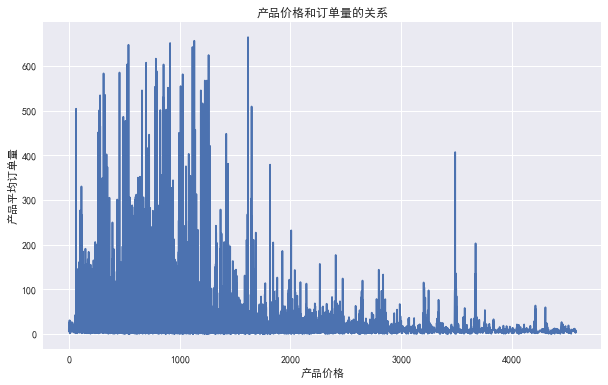

In [56]:
# 可视化产品价格和订单量的关系
sns.set_style('darkgrid')
plt.rcParams['font.sans-serif']=['SimHei']
plt.figure(figsize=(10, 6))
sns.lineplot(x='item_price', y='ord_qty', data=grouped)
plt.xlabel('产品价格')
plt.ylabel('产品平均订单量')
plt.title('产品价格和订单量的关系')
plt.show()

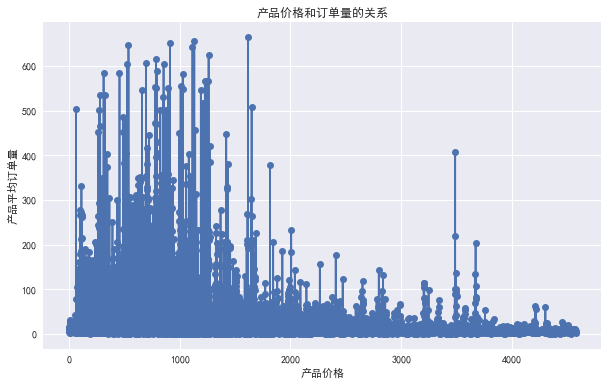

In [57]:
sns.set_style('darkgrid')
plt.rcParams['font.sans-serif']=['SimHei']
plt.figure(figsize=(10, 6))
plt.plot(grouped['item_price'], grouped['ord_qty'], 'o-')
plt.xlabel('产品价格')
plt.ylabel('产品平均订单量')
plt.title('产品价格和订单量的关系')
plt.show()

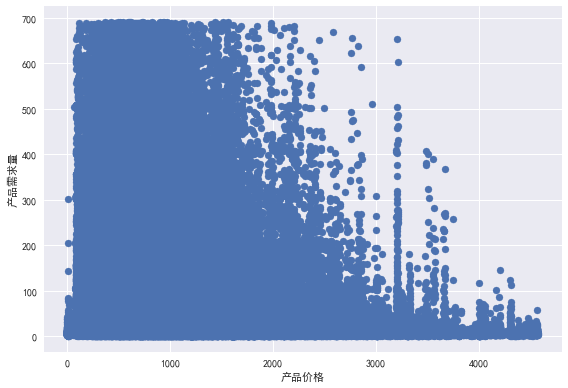

In [58]:
plt.scatter(df['item_price'], df['ord_qty'])
plt.xlabel('产品价格')
plt.ylabel('产品需求量')
plt.tight_layout()

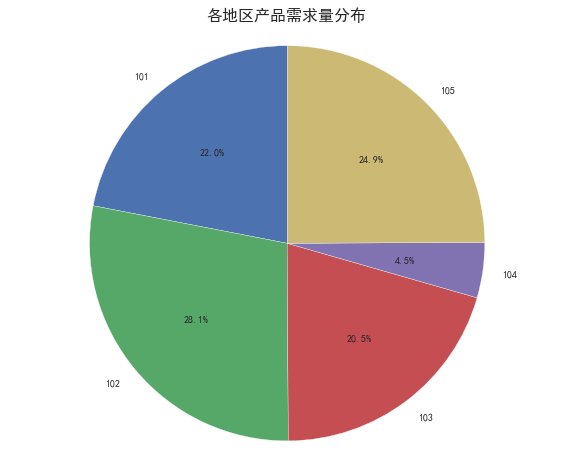

In [64]:
data_1 = df.groupby(['sales_region_code'])['ord_qty'].sum()
plt.figure(figsize=(10,8))
plt.pie(data_1.values, labels=data_1.index, autopct='%1.1f%%', startangle=90)
plt.title('各地区产品需求量分布', fontsize=16)
plt.axis('equal')
plt.show()

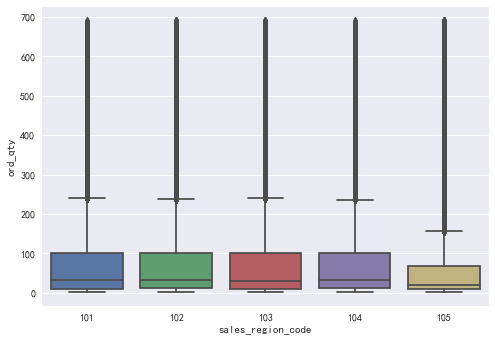

In [60]:
sns.boxplot(x='sales_region_code', y='ord_qty', data=df)
plt.show()

<AxesSubplot:xlabel='sales_region_code', ylabel='ord_qty'>

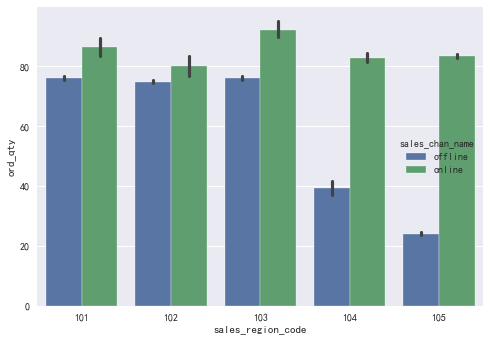

In [66]:
sns.barplot(x='sales_region_code', y='ord_qty', hue='sales_chan_name', data=df)

Text(0, 0.5, '销售量')

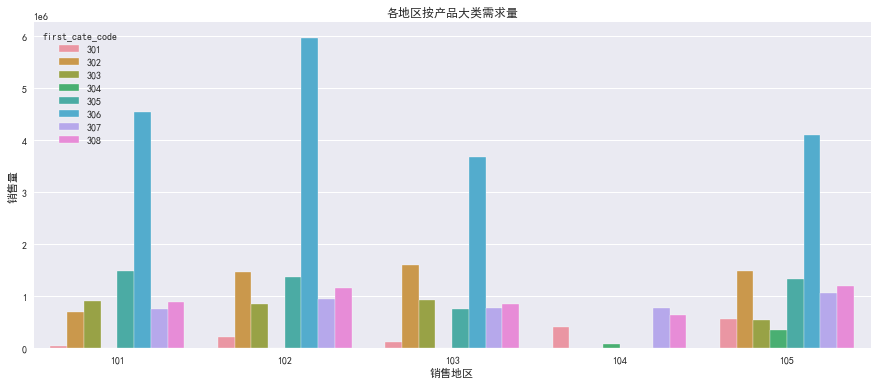

In [79]:
drop = df.drop(columns=['order_date'],axis=1)
grouped = drop.groupby(['sales_region_code', 'first_cate_code'])['ord_qty'].sum().reset_index()
fig, ax = plt.subplots(figsize=(15, 6))
sns.barplot(x='sales_region_code', y='ord_qty', hue='first_cate_code', data=grouped)
ax.set_title('各地区按产品大类需求量')
ax.set_xlabel('销售地区')
ax.set_ylabel('销售量')

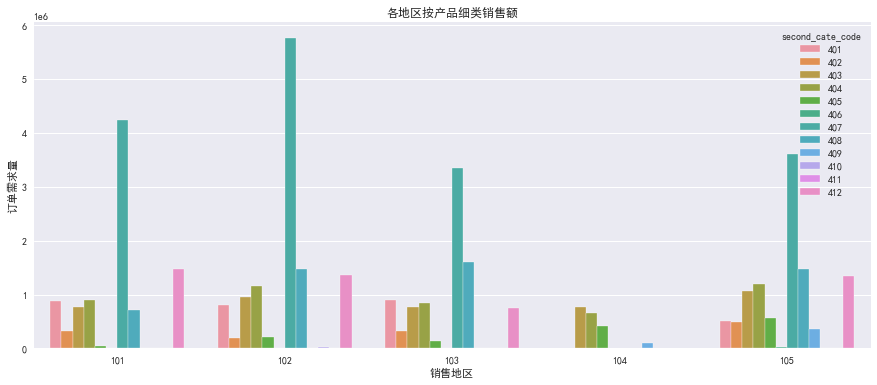

In [80]:
drop = df.drop(columns=['order_date'],axis=1)
grouped = drop.groupby(['sales_region_code', 'second_cate_code'])['ord_qty'].sum().reset_index()
plt.rcParams['font.sans-serif']=['SimHei']
fig, ax = plt.subplots(figsize=(15,6))
sns.barplot(x='sales_region_code', y='ord_qty', hue='second_cate_code', data=grouped)

ax.set_title('各地区按产品细类销售额')
ax.set_xlabel('销售地区')
ax.set_ylabel('订单需求量')

plt.show()

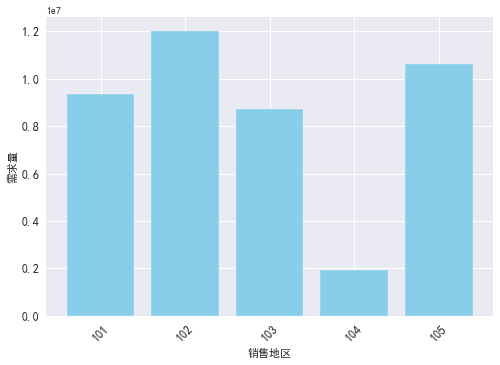

In [81]:
region_demand = df.groupby(['sales_region_code'])['ord_qty'].sum().reset_index()
region_demand
plt.rcParams['font.sans-serif']=['SimHei']

plt.bar(region_demand['sales_region_code'], region_demand['ord_qty'],color='skyblue')
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('销售地区')
plt.ylabel('需求量')
plt.show()

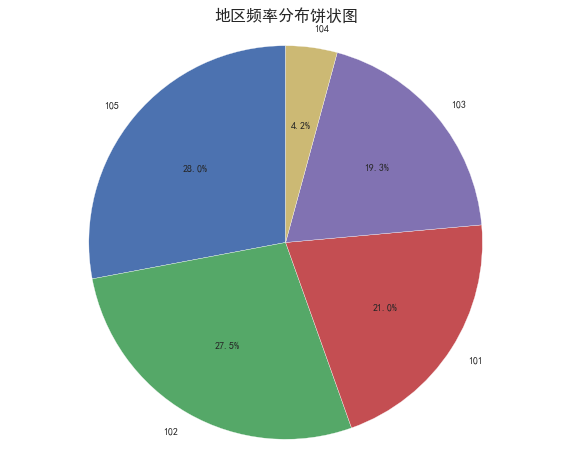

In [82]:
region_counts = df['sales_region_code'].value_counts()

# 绘制饼状图
plt.figure(figsize=(10,8))
plt.pie(region_counts.values, labels=region_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('地区频率分布饼状图', fontsize=16)
plt.axis('equal')
plt.show()

In [7]:
# 不同销售方式（线上和线下）的产品需求量的特性

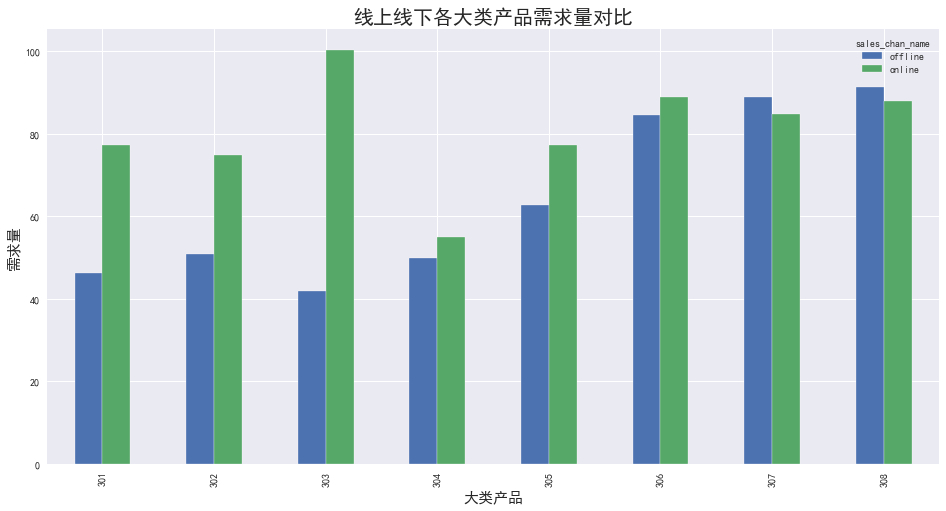

In [83]:
pivot_data = df.pivot_table(values='ord_qty', index='first_cate_code', columns='sales_chan_name')

# 绘制多重条形图
plt.rcParams['font.sans-serif']=['SimHei']
pivot_data.plot(kind='bar', figsize=(16, 8))
plt.title('线上线下各大类产品需求量对比', fontsize=20)
plt.xlabel('大类产品', fontsize=15)
plt.ylabel('需求量', fontsize=15)
plt.show()

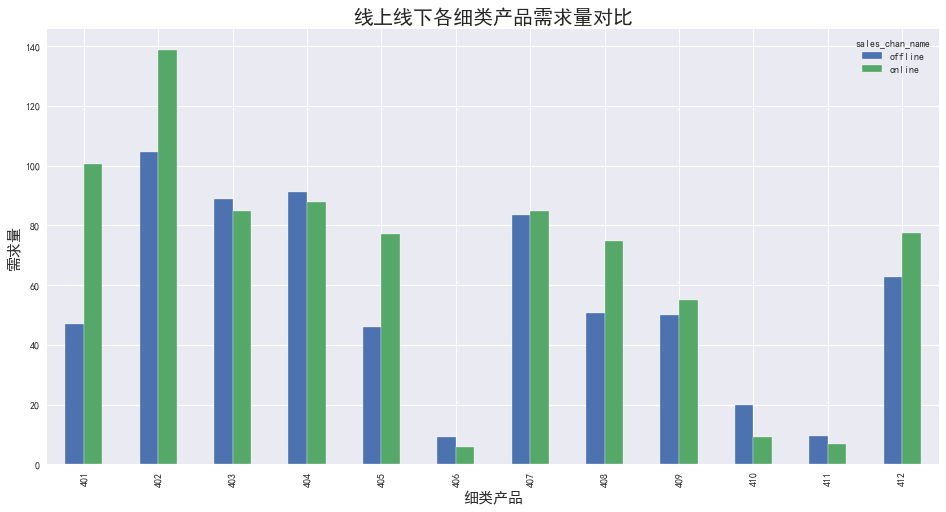

In [84]:
pivot_data = df.pivot_table(values='ord_qty', index='second_cate_code', columns='sales_chan_name')

# 绘制多重条形图
plt.rcParams['font.sans-serif']=['SimHei']
pivot_data.plot(kind='bar', figsize=(16, 8))
plt.title('线上线下各细类产品需求量对比', fontsize=20)
plt.xlabel('细类产品', fontsize=15)
plt.ylabel('需求量', fontsize=15)
plt.show()

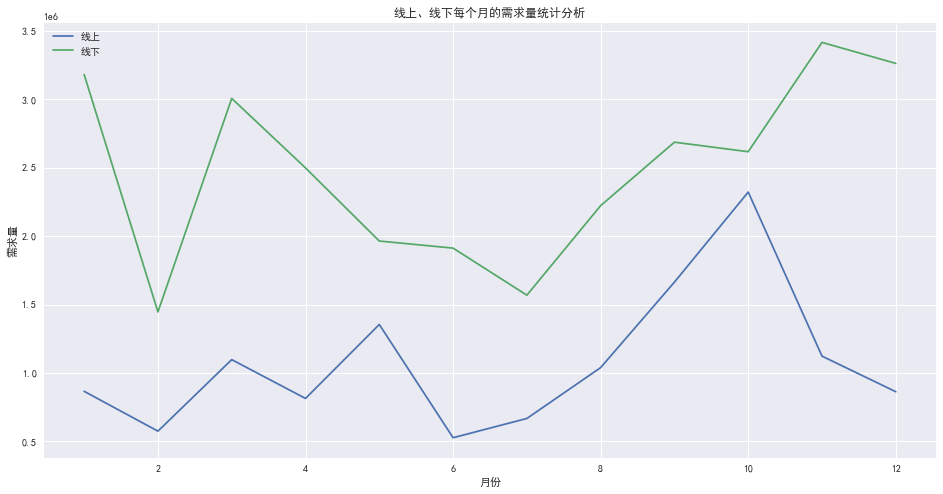

In [85]:
df["order_date"] = pd.to_datetime(df["order_date"], errors='coerce')

# 提取线上和线下的数据
online_data = df[df['sales_chan_name'] == 'online']
offline_data = df[df['sales_chan_name'] == 'offline']

# 将日期转换为 pandas 的日期类型
online_data['order_date'] = pd.to_datetime(online_data['order_date'])
offline_data['order_date'] = pd.to_datetime(offline_data['order_date'])

# 添加月份列
online_data['month'] = online_data['order_date'].dt.month
offline_data['month'] = offline_data['order_date'].dt.month

# 线上每月需求量统计
online_monthly_sales = online_data.groupby('month')['ord_qty'].sum()

# 线下每月需求量统计
offline_monthly_sales = offline_data.groupby('month')['ord_qty'].sum()

# 绘制线上、线下每个月的需求量统计分析图
plt.rcParams['font.sans-serif']=['SimHei']
plt.figure(figsize=(16, 8))
plt.plot(online_monthly_sales.index, online_monthly_sales.values, label='线上')
plt.plot(offline_monthly_sales.index, offline_monthly_sales.values, label='线下')
plt.xlabel('月份')
plt.ylabel('需求量')
plt.title('线上、线下每个月的需求量统计分析')
plt.legend()
plt.show()

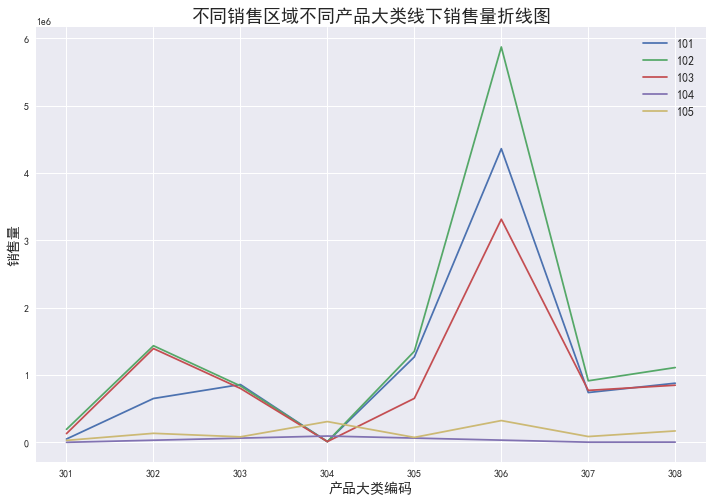

In [70]:
# 筛选线下销售数据
df_offline = df[df['sales_chan_name'] == 'offline']

# 分组统计销售量
df_grouped = df_offline.groupby(['sales_region_code', 'first_cate_code'])['ord_qty'].sum().reset_index()

# 绘制折线图
fig, ax = plt.subplots(figsize=(12, 8))
for region in df_grouped['sales_region_code'].unique():
    df_region = df_grouped[df_grouped['sales_region_code'] == region]
    ax.plot(df_region['first_cate_code'], df_region['ord_qty'], label=region)
ax.set_xlabel('产品大类编码', fontsize=14)
ax.set_ylabel('销售量', fontsize=14)
ax.set_title('不同销售区域不同产品大类线下销售量折线图', fontsize=18)
ax.legend(fontsize=12)
plt.show()

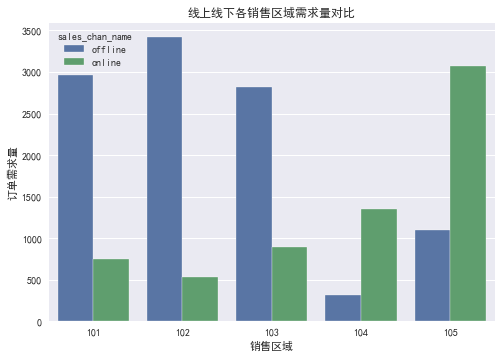

In [86]:
grouped_data = df.groupby(['sales_region_code', 'sales_chan_name'])['ord_qty'].sum().reset_index()
y_values=[x**0.5 for x in grouped_data['ord_qty']]
# 绘制柱状图
sns.barplot(x='sales_region_code', y=y_values, hue='sales_chan_name', data=grouped_data)

# 添加图标题和坐标轴标签
plt.title('线上线下各销售区域需求量对比')
plt.xlabel('销售区域')
plt.ylabel('订单需求量')

# 显示图形
plt.show()

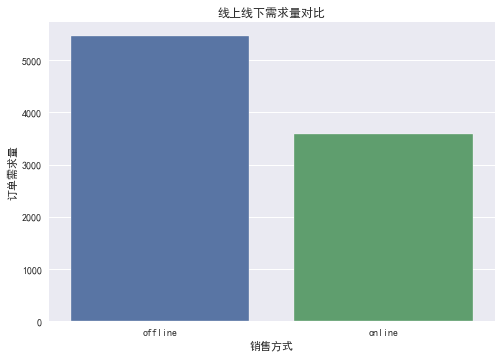

In [87]:
grouped_data = df.groupby(['sales_chan_name'])['ord_qty'].sum().reset_index()
# 绘制柱状图
y_values=[x**0.5 for x in grouped_data['ord_qty']]
sns.barplot(x='sales_chan_name', y=y_values,data=grouped_data)

# 添加图标题和坐标轴标签
plt.title('线上线下需求量对比')
plt.xlabel('销售方式')
plt.ylabel('订单需求量')

# 显示图形
plt.show()

<AxesSubplot:xlabel='item_price', ylabel='ord_qty'>

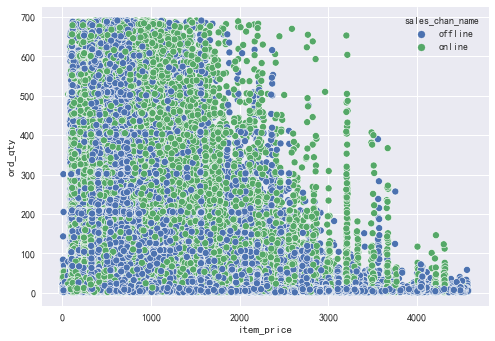

In [78]:
sns.scatterplot(data=df, x="item_price", y="ord_qty", hue="sales_chan_name")

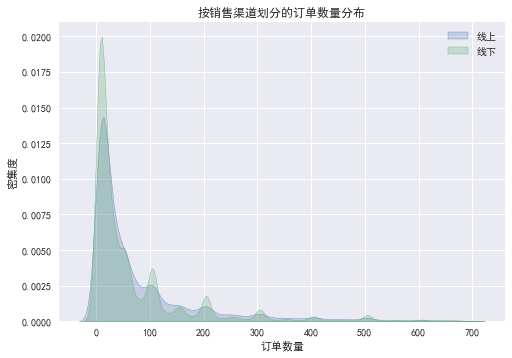

In [74]:
online_ord_qty = df[df["sales_chan_name"] == "online"]["ord_qty"]
offline_ord_qty = df[df["sales_chan_name"] == "offline"]["ord_qty"]

# 绘制线上和线下订单需求量核密度图
plt.rcParams['font.sans-serif']=['SimHei']
sns.kdeplot(online_ord_qty, shade=True, label="线上")
sns.kdeplot(offline_ord_qty, shade=True, label="线下")
plt.legend(loc="upper right")
plt.title("按销售渠道划分的订单数量分布")
plt.xlabel("订单数量")
plt.ylabel("密集度")
plt.show()

In [ ]:
# 为了解决第五问及以下问题 这里引用holidays库来做特征处理

In [88]:
import chinese_calendar
df["order_date"] = pd.to_datetime(df["order_date"], errors='coerce')
df["sales"] = (df["ord_qty"])*(df["item_price"])

df['Year'] = df.order_date.dt.year
df['Month'] = df.order_date.dt.month
df['day'] = df.order_date.dt.day
 
df['day of the week'] = df.order_date.dt.dayofweek 

def applyer(df_row):
    if chinese_calendar.is_workday(df_row):
        return 1
    else:
        return 0 
df['quarter'] = df.order_date.dt.quarter
df['is_month_start'] = df.order_date.dt.is_month_start.astype(int)
df['is_month_end'] = df.order_date.dt.is_month_end.astype(int)
df['is_quarter_start'] = df.order_date.dt.is_quarter_start.astype(int)
df['is_quarter_end'] = df.order_date.dt.is_quarter_end.astype(int)
df['is_year_start'] = df.order_date.dt.is_year_start.astype(int)
df['is_year_end'] = df.order_date.dt.is_year_end.astype(int)
df['is_workday'] = df['order_date'].apply(applyer)
df["is_holiday"] = df["order_date"].apply(chinese_calendar.is_holiday).astype(int)
dic = {"offline":1,"online":0}
df['sales_chan_name'] = df['sales_chan_name'].map(dic)

In [ ]:
# 不同时间段（例如月头、月中、月末等）产品需求量有何特性

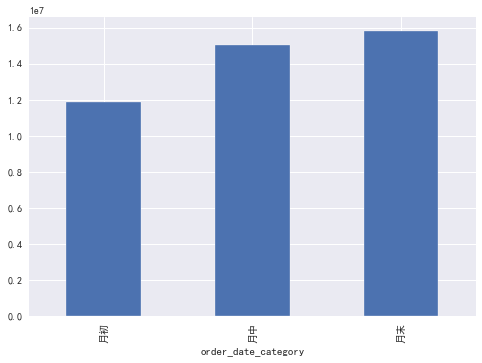

In [90]:
df['order_date'] = pd.to_datetime(df['order_date'])

# 根据订单日期将数据进行排序
df = df.sort_values(by='order_date')

# 按照月初、月中、月末将订单需求量进行分组
time_labels = ['月初', '月中', '月末']
time_bins = [0, 10, 20, 31]
df['order_date_category'] = pd.cut(df['order_date'].dt.day, bins=time_bins, labels=time_labels)

# 统计不同时间段的订单需求量
demand_by_time = df.groupby('order_date_category')['ord_qty'].sum()

# 绘制不同时间段的订单需求量柱状图
demand_by_time.plot(kind='bar')
plt.show()


#从图中可以看出，月初和月末的订单需求量较高，月中的订单需求量较低。
# 这可能与人们在月初和月末收入增加、有更多的购买能力有关，而在月中由于消费已经较多，购买能力下降导致订单需求量较低。

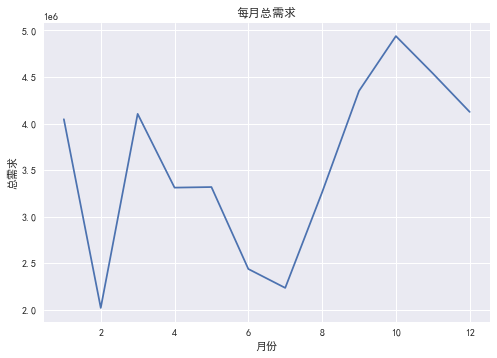

In [92]:
df['order_date'] = pd.to_datetime(df['order_date'])
df['month'] = df['order_date'].dt.month
grouped = df.groupby('month')

# 计算每个月份内的订单总需求量和平均需求量
total_qty_by_month = grouped['ord_qty'].sum()
mean_qty_by_month = grouped['ord_qty'].mean()

# 绘制订单总需求量的折线图
plt.plot(total_qty_by_month.index, total_qty_by_month.values)
plt.title('每月总需求')
plt.xlabel('月份')
plt.ylabel('总需求')
plt.show()

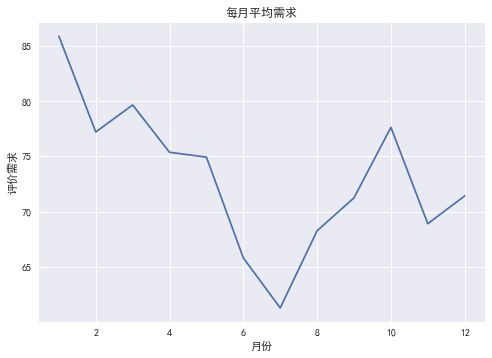

In [93]:
plt.plot(mean_qty_by_month.index, mean_qty_by_month.values)
plt.title('每月平均需求')
plt.xlabel('月份')
plt.ylabel('评价需求')
plt.show()

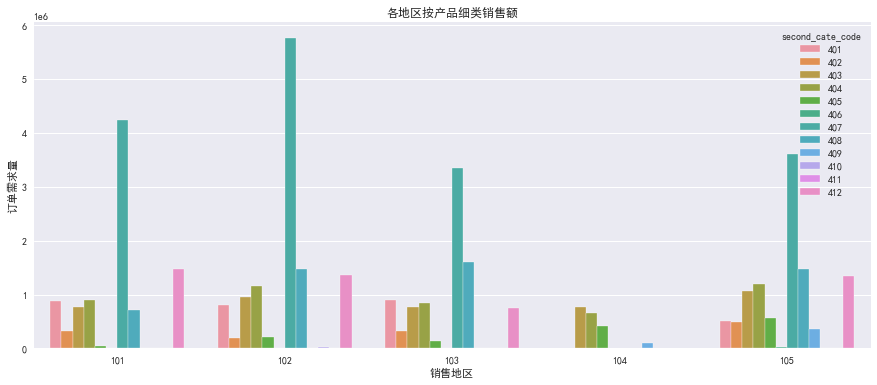

In [94]:
grouped = drop.groupby(['sales_region_code', 'second_cate_code'])['ord_qty'].sum().reset_index()
plt.rcParams['font.sans-serif']=['SimHei']
fig, ax = plt.subplots(figsize=(15,6))
sns.barplot(x='sales_region_code', y='ord_qty', hue='second_cate_code', data=grouped)
ax.set_title('各地区按产品细类销售额')
ax.set_xlabel('销售地区')
ax.set_ylabel('订单需求量')
plt.show()

In [ ]:
# 节假日对产品需求量的影响